In [1]:
import os
import pickle

import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch

import PIL
from skimage import io

In [2]:
import openslide

In [3]:
try:
    import multiresolutionimageinterface as mir
except ImportError as e:
    print(e)

In [4]:
from utils.file_utils import print_h5_file_info, check_h5_files_are_equal

In [5]:
camelyon16_data_path = 'data/camelyon16-test001'
camelyon16_patch_size = 256
subject_id = 'test_001'

# parameters used by authors for CAMELYON16 dataset
mask_downsapmle_level = 5
mask_downsample_factor = 2 ** mask_downsapmle_level

# from the original CAMELYON16 dataset
sample_slide_path = f'{camelyon16_data_path}/slides/{subject_id}.tif'
sample_xml_annotation_path = f'{camelyon16_data_path}/lesion_annotations/{subject_id}.xml'

# computed by the authors using the xml file and slide dimentions using multiresolutionimageinterface (example at the very end of the notebook)
sample_reference_mask_path = f'{camelyon16_data_path}/reference_masks/{subject_id}.png'

# patches shared by authours using the CLAM pipeline
sample_h5_patches_fp = f"{camelyon16_data_path}/patches_fp_shared_by_authors/patches/{subject_id}.h5"

# ground truth patch indexes computed by authors for the patches created by CLAM pipeline using patch coordinates and lesion annotations xml file
sample_pickle_gt_path = f'{camelyon16_data_path}/gt_patches_indexes/{subject_id}.pkl'

# features computed by authors after creating patches with CLAM pipeline
sample_h5_features_file_path = f'{camelyon16_data_path}/features_shared_by_authors/h5_files/{subject_id}.h5'
sample_pt_features_file_path = f'{camelyon16_data_path}/features_shared_by_authors/pt_files/{subject_id}.pt'
if not os.path.exists(sample_pt_features_file_path):
    with h5py.File(sample_h5_features_file_path, "r") as f:
        feats_pt_from_hdf5 = torch.from_numpy(f['features'][:])
        torch.save(feats_pt_from_hdf5, sample_pt_features_file_path)

# can be computed using 'coords' (either patches or features file) from the h5 files shared by the authors
tissue_mask_downsampled_path = f"{camelyon16_data_path}/tissue_masks_created_from_h5_coords/{subject_id}.png"

# computed by GeorgeBatch from the xml file using ASAP multiresolutionimageinterface (mir)
sample_from_xml_reference_mask_mir_path = f'{camelyon16_data_path}/masks_created_from_xml/{subject_id}_ASAP_mir.tif'
sample_from_xml_reference_mask_openslide_path = f'{camelyon16_data_path}/masks_created_from_xml/{subject_id}_ASAP_openslide.tif'

In [6]:
# can be changed - just used as an example of a region where the lesion is present
example_region_downsample_level = 4
example_region_xy = (14000, 10000)
example_region_size = (1000, 1000)

## Openslide

Level 0
	 Dimensions (width, height): (86016, 89600)
	 Downsample: 1.0
Level 1
	 Dimensions (width, height): (43008, 44800)
	 Downsample: 2.0
Level 2
	 Dimensions (width, height): (21504, 22400)
	 Downsample: 4.0
Level 3
	 Dimensions (width, height): (10752, 11200)
	 Downsample: 8.0
Level 4
	 Dimensions (width, height): (5376, 5600)
	 Downsample: 16.0
Level 5
	 Dimensions (width, height): (2688, 2800)
	 Downsample: 32.0
Level 6
	 Dimensions (width, height): (1344, 1400)
	 Downsample: 64.0
Level 7
	 Dimensions (width, height): (672, 700)
	 Downsample: 128.0
Level 8
	 Dimensions (width, height): (336, 350)
	 Downsample: 256.0


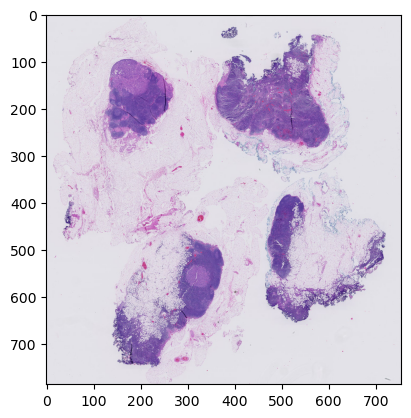

In [7]:
openslide_slide = openslide.open_slide(sample_slide_path)

for i in range(openslide_slide.level_count):
    print(f'Level {i}')
    print(f'\t Dimensions (width, height): {openslide_slide.level_dimensions[i]}')
    print(f'\t Downsample: {openslide_slide.level_downsamples[i]}')

plt.imshow(openslide_slide.get_thumbnail((786, 786)))
plt.show()

downsample_level : 4
downsample_factor: 16.0


(1000, 1000)

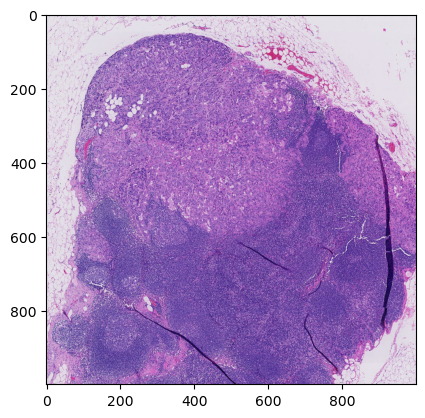

In [8]:
downsample_factor = openslide_slide.level_downsamples[example_region_downsample_level]
print("downsample_level :", example_region_downsample_level)
print("downsample_factor:", downsample_factor)
assert downsample_factor == 2 ** example_region_downsample_level

image_patch = openslide_slide.read_region(
    example_region_xy,
    example_region_downsample_level,
    example_region_size
)
plt.imshow(image_patch)
image_patch.size

In [9]:
for key, value in openslide_slide.properties.items():
    print(key, value)

openslide.level-count 9
openslide.level[0].downsample 1
openslide.level[0].height 89600
openslide.level[0].tile-height 512
openslide.level[0].tile-width 512
openslide.level[0].width 86016
openslide.level[1].downsample 2
openslide.level[1].height 44800
openslide.level[1].tile-height 512
openslide.level[1].tile-width 512
openslide.level[1].width 43008
openslide.level[2].downsample 4
openslide.level[2].height 22400
openslide.level[2].tile-height 512
openslide.level[2].tile-width 512
openslide.level[2].width 21504
openslide.level[3].downsample 8
openslide.level[3].height 11200
openslide.level[3].tile-height 512
openslide.level[3].tile-width 512
openslide.level[3].width 10752
openslide.level[4].downsample 16
openslide.level[4].height 5600
openslide.level[4].tile-height 512
openslide.level[4].tile-width 512
openslide.level[4].width 5376
openslide.level[5].downsample 32
openslide.level[5].height 2800
openslide.level[5].tile-height 512
openslide.level[5].tile-width 512
openslide.level[5].width

## Ground Truth Pickle files

In [10]:
with open(sample_pickle_gt_path, 'rb') as f:
    gt_patches_indexes = pickle.load(f)

In [11]:
type(gt_patches_indexes), len(gt_patches_indexes)

(list, 1506)

In [12]:
gt_patches_indexes_np = np.array(gt_patches_indexes)

In [13]:
gt_patches_indexes_np[:10], gt_patches_indexes_np[-10:]

(array([ 3167,  9664,  9435,  9681,  9891, 10264,  9383, 10339,  9064,
         9966]),
 array([2540, 4070, 2851, 3156, 3168, 3947, 2547, 2928, 3546, 4007]))

In [14]:
min(gt_patches_indexes_np), max(gt_patches_indexes_np), max(gt_patches_indexes_np) - min(gt_patches_indexes_np)

(2387, 12180, 9793)

## Tumor (Reference) Mask from the original dataset

data/camelyon16-test001/reference_masks/test_001.png
(2688, 2800)


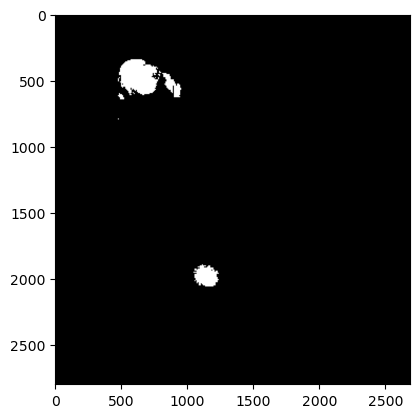

In [15]:
print(sample_reference_mask_path)
sample_reference_mask = PIL.Image.open(sample_reference_mask_path)
print(sample_reference_mask.size) # (width, height)

plt.imshow(sample_reference_mask)
plt.show()

In [16]:
# (total slide width, total slide hieght) / (total mask width, total mask height)
np.array(openslide_slide.dimensions) / np.array(sample_reference_mask.size)

array([32., 32.])

In [17]:
sample_reference_mask_np = np.array(sample_reference_mask)
print("shape:", sample_reference_mask_np.shape)  # (height, width, channels) <=> (row, col, colour)
print("unique:", np.unique(sample_reference_mask_np))
print("range:", sample_reference_mask_np.min(axis=(0, 1)), sample_reference_mask_np.max(axis=(0, 1)))

sample_reference_mask_np_larger_side = max(sample_reference_mask_np.shape[:2])
print("larger side:", sample_reference_mask_np_larger_side)

shape: (2800, 2688, 3)
unique: [  0 255]
range: [0 0 0] [255 255 255]
larger side: 2800


In [18]:
sample_reference_mask_np_binary = (
    sample_reference_mask_np.mean(axis=2, keepdims=True) / 255).astype(int)

print("shape:", sample_reference_mask_np_binary.shape)
print("unique:", np.unique(sample_reference_mask_np_binary))
print("range:", sample_reference_mask_np_binary.min(), sample_reference_mask_np_binary.max())

shape: (2800, 2688, 1)
unique: [0 1]
range: 0 1


In [19]:
(sample_reference_mask_np == [255, 255, 255]).sum() / (mask_downsample_factor ** 2)

282.375

In [20]:
slide_thumbnail_np = np.array(
    openslide_slide.get_thumbnail((sample_reference_mask_np_larger_side, sample_reference_mask_np_larger_side))
)
slide_thumbnail_np.shape

(2800, 2688, 3)

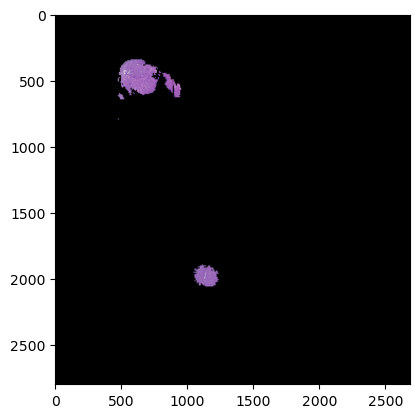

In [21]:
plt.imshow(slide_thumbnail_np * sample_reference_mask_np_binary)
plt.show()

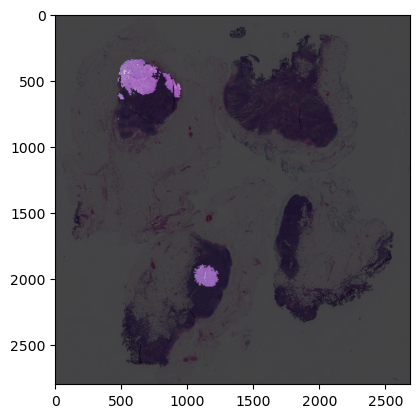

In [22]:
alpha = 0.3
sample_reference_mask_np_transparency = np.clip(
    sample_reference_mask_np_binary,
    alpha, 1
)

plt.imshow((slide_thumbnail_np * sample_reference_mask_np_transparency).astype(int))
plt.show()

## patches_fp HDF5 file with 'coords' and metadata - shared by the authors

In [23]:
# not using print_h5_file_info because we need to get coords_wo_features_np

print_h5_file_info(sample_h5_patches_fp)

with h5py.File(sample_h5_patches_fp, 'r') as f:
    coords_wo_features_np = f['coords'][:]

File attributes: <KeysViewHDF5 []>
File keys: <KeysViewHDF5 ['coords']>
Key 0: <coords>
Dataset <coords> length: 18837
Dataset <coords> shape: (18837, 2)
Dataset <coords> attribute keys: <KeysViewHDF5 ['downsample', 'downsampled_level_dim', 'level_dim', 'name', 'patch_level', 'patch_size', 'save_path']>

	 downsample [1. 1.]
	 downsampled_level_dim [86016 89600]
	 level_dim [86016 89600]
	 name test_001
	 patch_level 0
	 patch_size 256
	 save_path data/camelyon16-test001/patches_fp_from_tile_coords/patches

(2,) [16128 77248]
(2,) [16128 77504]
(2,) [16128 77760]
(2,) [16384 74176]
(2,) [16384 75200]
(2,) [16384 75456]
(2,) [16384 75712]
(2,) [16384 76736]
(2,) [16384 76992]
(2,) [16384 77248]



## features HDF5 file with 'coords' and 'features' shared by the authors

In [24]:
print_h5_file_info(sample_h5_features_file_path)

with h5py.File(sample_h5_features_file_path, 'r') as f:
    tissue_coords_np = f['coords'][:]

print(tissue_coords_np.shape)
print(tissue_coords_np.min(axis=0), tissue_coords_np.max(axis=0))

File attributes: <KeysViewHDF5 []>
File keys: <KeysViewHDF5 ['coords', 'features']>
Key 0: <coords>
Dataset <coords> length: 18837
Dataset <coords> shape: (18837, 2)
Dataset <coords> attribute keys: <KeysViewHDF5 []>


(2,) [16128 77248]
(2,) [16128 77504]
(2,) [16128 77760]
(2,) [16384 74176]
(2,) [16384 75200]
(2,) [16384 75456]
(2,) [16384 75712]
(2,) [16384 76736]
(2,) [16384 76992]
(2,) [16384 77248]

Key 1: <features>
Dataset <features> length: 18837
Dataset <features> shape: (18837, 1024)
Dataset <features> attribute keys: <KeysViewHDF5 []>


(1024,) [0.11323719 0.00936267 0.03324208 ... 0.0058881  0.03015733 0.07728295]
(1024,) [0.11989184 0.0080205  0.02506619 ... 0.00250075 0.02684664 0.07801539]
(1024,) [0.11277454 0.01166185 0.0099317  ... 0.01005862 0.0235211  0.11328335]
(1024,) [0.09431148 0.01821768 0.01615209 ... 0.00244805 0.0196411  0.10336559]
(1024,) [0.09023681 0.00948272 0.01911643 ... 0.00337741 0.01525629 0.08077317]
(1024,) [0.09187657 0.01636523 0.02387656 ..

In [25]:
# check that the coordinates from the file with features and without match
assert (coords_wo_features_np == tissue_coords_np).all()

In [26]:
print(sample_slide_path)
openslide_slide = openslide.open_slide(sample_slide_path)
openslide_slide.dimensions

data/camelyon16-test001/slides/test_001.tif


(86016, 89600)

In [27]:
# check if the coordinates are multiples of 64 and 128
#   of 64, but not of 128 
(tissue_coords_np % 64 == 0).all(), (tissue_coords_np % 128 == 0).all()

(True, False)

In [28]:
tissue_coords_np[gt_patches_indexes_np].shape

(1506, 2)

### Make a reference mask using shared 'coords' and gt_patch_indexes pickle

8
[136 162] [2552 2662]

0 1


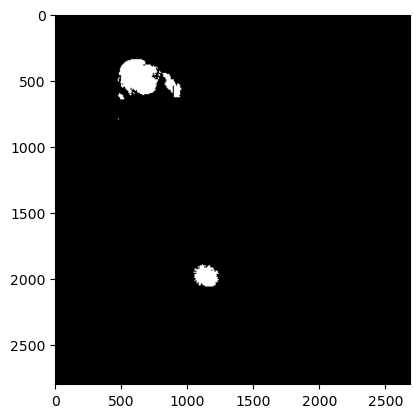

In [29]:
# make a mask from tissue_coords_np / mask_downsample_factor taking the indexes from gt_patches_indexes_np to be 1 and all the other to be 0
# camelyon16 patch size was 256 in MS-CLAM

assert camelyon16_patch_size % mask_downsample_factor == 0
downsampled_patch_size = camelyon16_patch_size // mask_downsample_factor
print(downsampled_patch_size)

tissue_coords_np_downsampled = (tissue_coords_np / mask_downsample_factor).astype(int)

print(tissue_coords_np_downsampled.min(axis=0), tissue_coords_np_downsampled.max(axis=0))
print()


np.array(openslide_slide.dimensions) // mask_downsample_factor == np.array(sample_reference_mask_np.shape)[[1, 0]]
# make a 0-mask
tumor_mask_downsampled = np.zeros(
    np.array(openslide_slide.dimensions) // mask_downsample_factor,
    # tissue_coords_np_downsampled64.max(axis=0) + 1,
    dtype=int)
# set the indexes from gt_patches_indexes_np to 1
# plt.imshow(tumor_mask_downsampled,)


x_coords, y_coords = tissue_coords_np_downsampled[gt_patches_indexes_np].T
for x, y in zip(x_coords, y_coords):
    tumor_mask_downsampled[x:x+downsampled_patch_size,
                       y:y+downsampled_patch_size] = 1

print(tumor_mask_downsampled.min(), tumor_mask_downsampled.max())


tumor_mask_downsampled_transposed = tumor_mask_downsampled.T

# check that the masks match
assert (tumor_mask_downsampled_transposed ==
        sample_reference_mask_np_binary[:, :, 0]).all()

# bw = ListedColormap(['black', 'white'])
# plt.imshow(tumor_mask_downsampled, cmap=bw)
plt.imshow(tumor_mask_downsampled_transposed, cmap='gray')
plt.show()

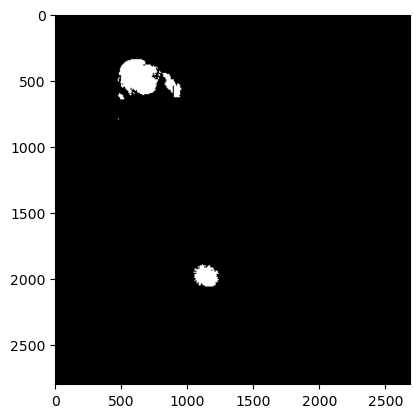

In [30]:
plt.imshow(
    PIL.Image.fromarray(
        (tumor_mask_downsampled_transposed * 255).astype(np.uint8)
        ) #.save('mask_downsampled_pil.png')
    , cmap='gray'
)
plt.show()

In [31]:
sample_reference_mask_np_binary.shape, tumor_mask_downsampled_transposed.shape

((2800, 2688, 1), (2800, 2688))

In [32]:
sample_reference_mask_np_binary[:, :, 0].max(
), tumor_mask_downsampled_transposed.max()

(1, 1)

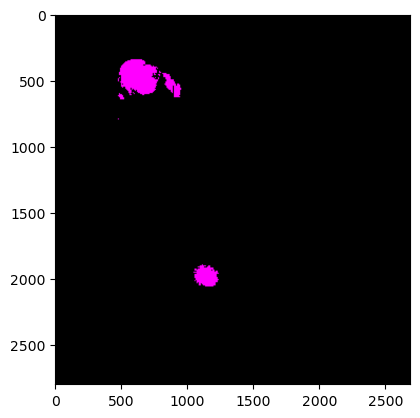

In [33]:
masks_overlay = np.stack(
    # (red, green, blue) channels
    [
        sample_reference_mask_np_binary[:, :, 0],
        np.zeros_like(tumor_mask_downsampled_transposed),
        tumor_mask_downsampled_transposed,
    ],                  
    axis=-1
)
plt.imshow((PIL.Image.fromarray((masks_overlay * 255).astype(np.uint8))))
plt.show()

In [34]:
# check that the masks match
assert (tumor_mask_downsampled_transposed == sample_reference_mask_np_binary[:, :,0]).all()

### Tissue Mask recovered using the 'coords' from the HDF5 file

In [35]:
print(sample_h5_patches_fp)
print_h5_file_info(sample_h5_patches_fp)

data/camelyon16-test001/patches_fp_shared_by_authors/patches/test_001.h5
File attributes: <KeysViewHDF5 []>
File keys: <KeysViewHDF5 ['coords']>
Key 0: <coords>
Dataset <coords> length: 18837
Dataset <coords> shape: (18837, 2)
Dataset <coords> attribute keys: <KeysViewHDF5 ['downsample', 'downsampled_level_dim', 'level_dim', 'name', 'patch_level', 'patch_size', 'save_path']>

	 downsample [1. 1.]
	 downsampled_level_dim [86016 89600]
	 level_dim [86016 89600]
	 name test_001
	 patch_level 0
	 patch_size 256
	 save_path data/camelyon16-test001/patches_fp_from_tile_coords/patches

(2,) [16128 77248]
(2,) [16128 77504]
(2,) [16128 77760]
(2,) [16384 74176]
(2,) [16384 75200]
(2,) [16384 75456]
(2,) [16384 75712]
(2,) [16384 76736]
(2,) [16384 76992]
(2,) [16384 77248]



8
[136 162] [2552 2662]

0 1


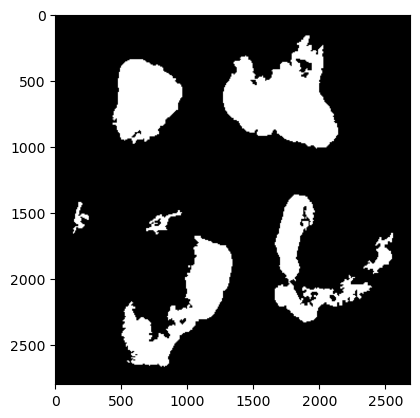

In [36]:
# make a mask from tissue_coords_np / 64 taking the indexes from gt_patches_indexes_np to be 1 and all the other to be 0
# use the minimum and maximum of the coordinates in both axis to make the mask

# camelyon16 patch size was 256 in MS-CLAM

assert camelyon16_patch_size % mask_downsample_factor == 0
downsampled_patch_size = camelyon16_patch_size // mask_downsample_factor
print(downsampled_patch_size)

tissue_coords_np_downsampled = (tissue_coords_np / mask_downsample_factor).astype(int)

print(tissue_coords_np_downsampled.min(axis=0), tissue_coords_np_downsampled.max(axis=0))
print()


np.array(openslide_slide.dimensions) // mask_downsample_factor == np.array(
    sample_reference_mask_np.shape)[[1, 0]]
# make a 0-mask
tissue_mask_downsampled = np.zeros(
    np.array(openslide_slide.dimensions) // mask_downsample_factor,
    # tissue_coords_np_downsampled64.max(axis=0) + 1,
    dtype=int)

x_coords, y_coords = tissue_coords_np_downsampled[:].T
for x, y in zip(x_coords, y_coords):
    tissue_mask_downsampled[x:x+downsampled_patch_size,
                     y:y+downsampled_patch_size] = 1

print(tissue_mask_downsampled.min(), tissue_mask_downsampled.max())


tissue_mask_downsampled_transposed = tissue_mask_downsampled.T

plt.imshow(tissue_mask_downsampled_transposed, cmap='gray')

os.makedirs(os.path.dirname(tissue_mask_downsampled_path), exist_ok=True)
plt.imsave(tissue_mask_downsampled_path, tissue_mask_downsampled_transposed, cmap='gray')

### Tissue Mask - Tumor mask overlay

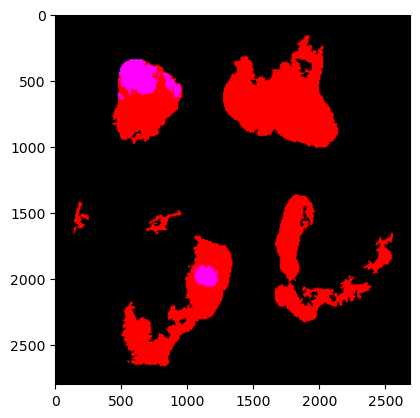

In [37]:
tissue_tumor_masks_overlay = np.stack(
    # (red, green, blue) channels
    [
        tissue_mask_downsampled_transposed,                 # red tissue   
        np.zeros_like(tissue_mask_downsampled_transposed),  # zero green
        tumor_mask_downsampled_transposed,                  # blue tumor
    ],
    axis=-1
)
plt.imshow(PIL.Image.fromarray((tissue_tumor_masks_overlay * 255).astype(np.uint8)))
plt.show()

## Check that the feature extraction was successful

Follow the instructions from the README, but use the single-slide example to speed up the process as described below.

To extract features, use [extract_features_fp.py](https://github.com/mahmoodlab/CLAM/blob/master/extract_features_fp.py) as shown below. You can speed up the process if you have a GPU with more memory or even multiple GPUs by
- increasing the `batch_size` parameter, e.g. to 1024
- setting `CUDA_VISIBLE_DEVICES=0,1,2,3` if you have 4 GPUs

```shell
# tmux new-session -s extract-camelyon16-test001-features
# tmux attach -t extract-camelyon16-test001-features
# conda activate msclam

# patches_fp has the coordinates shared by the authors of MS-CLAM
CUDA_VISIBLE_DEVICES=0 python extract_features_fp.py \
  --data_h5_dir ../MS-CLAM/data/camelyon16-test001/patches_fp_shared_by_authors/ \
  --data_slide_dir ../MS-CLAM/data/camelyon16-test001/slides \
  --csv_path ../MS-CLAM/data/camelyon16-test001/patches_fp_shared_by_authors/process_list.csv \
  --feat_dir ../MS-CLAM/data/camelyon16-test001/features/ \
  --batch_size 256 \
  --slide_ext .tif
```

In [38]:
assert torch.allclose(
    torch.load(
        sample_pt_features_file_path, map_location='cpu'),
    torch.load(
        "data/camelyon16-test001/features/pt_files/test_001.pt", map_location='cpu'),
    atol=1e-7
)

In [39]:
assert check_h5_files_are_equal(
    sample_h5_features_file_path,
    "data/camelyon16-test001/features/h5_files/test_001.h5",
    atol=1e-7
)

The files are the same.


## Find Indexes all tissue patches within tumour polygons in XML files

This method should result in a similar set of indexes to the `gt_patches_indexes_np`

In [40]:
import h5py
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, Point


def parse_xml_to_polygons(xml_fp):
    tree = ET.parse(xml_fp)
    root = tree.getroot()

    polygons = []
    for annotation in root.find('Annotations').findall('Annotation'):
        coords = annotation.find('Coordinates')
        points = [(float(coord.attrib['X']), float(coord.attrib['Y'])) for coord in coords.findall('Coordinate')]
        polygon = Polygon(points)
        polygons.append(polygon)
    
    return polygons


def get_patch_centers(top_left_coords, patch_size):
    centers = top_left_coords + patch_size // 2
    return centers


def get_patches_within_polygons(patch_centers, polygons):
    indexes = []
    for i, center in enumerate(patch_centers):
        point = Point(center)
        if any(polygon.contains(point) for polygon in polygons):
            indexes.append(i)
    return indexes

# ---------------------------------------------------------------------------

# Parse the XML file to get the polygons
polygons = parse_xml_to_polygons(sample_xml_annotation_path)
print(f"{len(polygons)} Polygons:\n", polygons[:2], "...\n")

# Load the HDF5 file and get the coordinates of patches
with h5py.File(sample_h5_patches_fp, 'r') as f:
    coords_wo_features_np = f['coords'][:]
    patch_size = f['coords'].attrs['patch_size']

# Get the patch centers
patch_centers = get_patch_centers(coords_wo_features_np, patch_size)
print(f"{len(patch_centers)} Patch centers:\n", patch_centers[:5], "...\n")

# Get the indexes of patches that are within the polygons
tumour_patch_indexes = sorted(get_patches_within_polygons(patch_centers, polygons))
print(f"{len(tumour_patch_indexes)} Tumour patch indexes:\n", tumour_patch_indexes[:5], "...\n")

30 Polygons:
 [<POLYGON ((36904.3 66020.5, 36862.1 66004.9, 36818.7 65987.2, 36775.4 65967....>, <POLYGON ((34012.6 64741.8, 34009.7 64702.3, 34042.7 64674.1, 34061.5 64639....>] ...

18837 Patch centers:
 [(16256.0, 77376.0), (16256.0, 77632.0), (16256.0, 77888.0), (16512.0, 74304.0), (16512.0, 75328.0)] ...

1523 Tumour patch indexes:
 [2387, 2460, 2461, 2463, 2464] ...



In [41]:
print("In tumour_patch_indexes (computed now), but not in gt_patches_indexes_np (shared by the authors):", len(set(tumour_patch_indexes) - set(gt_patches_indexes_np)))
print("In gt_patches_indexes_np (shared by the authors), but not in tumour_patch_indexes (computed now):", len(set(gt_patches_indexes_np) - set(tumour_patch_indexes)))

In tumour_patch_indexes (computed now), but not in gt_patches_indexes_np (shared by the authors): 67
In gt_patches_indexes_np (shared by the authors), but not in tumour_patch_indexes (computed now): 50


## ASAP for making a mask from xml annotation files

1. Download [ASAP](https://github.com/computationalpathologygroup/ASAP)

2. Add these lines to `~/.bashrc`:
    ```
    # Add the path to the ASAP (https://github.com/computationalpathologygroup/ASAP) bin directory
    export PYTHONPATH=$PYTHONPATH:/opt/ASAP/bin
    ```
   
3. Close and open shell for the changes to take place.

Instructions from: https://camelyon17.grand-challenge.org/Data/


**Issues that it's useful to check**

1. **Problem**: Mask empty: https://github.com/computationalpathologygroup/ASAP/issues/205
**Solution**: Fix label map to correspond to the xml groups. See issue comment.


2. **Problem**: Opening mask with openslide results in an empty mask, while ASAP works: https://github.com/computationalpathologygroup/ASAP/issues/143
**Solution**: Be careful with the channels when opening openslide. See issue comment.


3. **Problem**: Mask making is too slow: https://github.com/computationalpathologygroup/ASAP/issues/195
**Solution**: Lower the resolution, **how???**

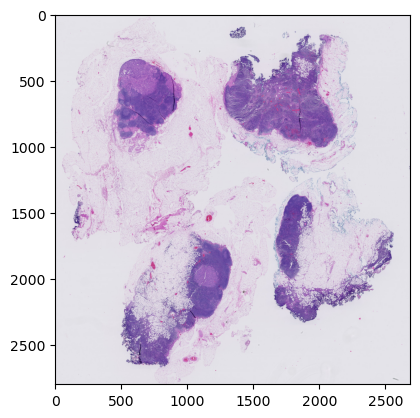

In [42]:
reader = mir.MultiResolutionImageReader()
mr_image = reader.open(sample_slide_path)

image_thumbnail = mr_image.getUCharPatch(
    0, 0,
    mr_image.getLevelDimensions(mask_downsapmle_level)[0], mr_image.getLevelDimensions(mask_downsapmle_level)[1],
    mask_downsapmle_level
)
plt.imshow(image_thumbnail)

16.0


3000000

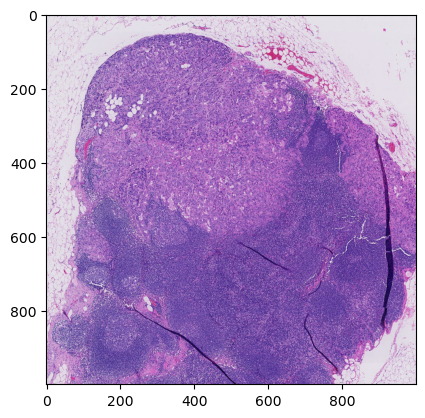

In [43]:
downsample_factor = mr_image.getLevelDownsample(example_region_downsample_level)
print(downsample_factor)
image_patch = mr_image.getUCharPatch(
    *example_region_xy,     # *(x, y) -> x, y
    *example_region_size,
    example_region_downsample_level
)
plt.imshow(image_patch)
image_patch.size

In [44]:
annotation_list = mir.AnnotationList()
xml_repository = mir.XmlRepository(annotation_list)
xml_repository.setSource(sample_xml_annotation_path)
xml_repository.load()

True

In [45]:
[el for el in dir(annotation_list.getAnnotation(0)) if not el.startswith('_')]

['Type_DOT',
 'Type_MEASUREMENT',
 'Type_NONE',
 'Type_POINTSET',
 'Type_POLYGON',
 'Type_RECTANGLE',
 'Type_SPLINE',
 'addCoordinate',
 'clearCoordinates',
 'getArea',
 'getCenter',
 'getColor',
 'getCoordinate',
 'getCoordinates',
 'getGroup',
 'getImageBoundingBox',
 'getLocalBoundingBox',
 'getName',
 'getNumberOfPoints',
 'getType',
 'getTypeAsString',
 'insertCoordinate',
 'isClockwise',
 'isModified',
 'removeCoordinate',
 'resetModifiedStatus',
 'setColor',
 'setCoordinates',
 'setGroup',
 'setName',
 'setType',
 'setTypeFromString',
 'simplify',
 'this',
 'thisown']

In [46]:
print(annotation_list.getAnnotation(0).getName())
print(annotation_list.getAnnotation(0).getNumberOfPoints())


Annotation 0
1033


In [47]:
annotation_mask = mir.AnnotationToMask()

dataset_2_convert_args = {
    'camelyon16': {
        'label_map': {'Tumor': 1, 'Normal': 2},
        'conversion_order': ['Tumor', 'Normal']
    },
    'camelyon17': {
        'label_map': {'metastases': 1, 'normal': 2},
        'conversion_order': ['metastases', 'normal']
    },
    'default': {
        'label_map': {'_0': 1, '_1': 1, '_2': 0},
        'conversion_order': ['_0', '_1', '_2']
    }
}

dataset_name = 'camelyon16'
label_map = dataset_2_convert_args.get(dataset_name, dataset_2_convert_args['default'])['label_map']
conversion_order = dataset_2_convert_args.get(dataset_name, dataset_2_convert_args['default'])['conversion_order']

print(label_map)
print(conversion_order)


{'Tumor': 1, 'Normal': 2}
['Tumor', 'Normal']


In [48]:
os.makedirs(os.path.dirname(sample_from_xml_reference_mask_mir_path), exist_ok=True)
annotation_mask.convert(
    annotation_list,
    sample_from_xml_reference_mask_mir_path,
    mr_image.getDimensions(),
    mr_image.getSpacing(),
    label_map,
    conversion_order,
)

Total time was 44120
Total reading time was 0
Total base writing time was 2
Total pyramid downsampling time was 0
Total pyramid writing time was 44118
Total time determining min/max was 0


sample_from_xml_reference_mask_mir_path data/camelyon16-test001/masks_created_from_xml/test_001_ASAP_mir.tif
mask_downsapmle_level 5
Mask Dimentions (86016, 89600)
Min value: 0.0
Max value: 1.0


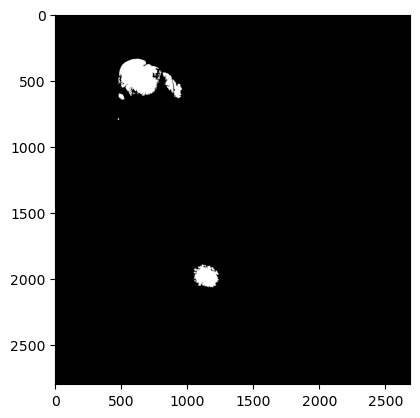

In [49]:
print("sample_from_xml_reference_mask_mir_path", sample_from_xml_reference_mask_mir_path)
print("mask_downsapmle_level", mask_downsapmle_level)

mr_mask = reader.open(sample_from_xml_reference_mask_mir_path)
print("Mask Dimentions", mr_mask.getDimensions())
print("Min value:", mr_mask.getMinValue())
print("Max value:", mr_mask.getMaxValue())


mr_mask_thumbnail = mr_mask.getUCharPatch(
    0, 0,
    mr_image.getLevelDimensions(mask_downsapmle_level)[0], mr_image.getLevelDimensions(mask_downsapmle_level)[1],
    mask_downsapmle_level
)
plt.imshow(mr_mask_thumbnail, cmap='gray')

sample_from_xml_reference_mask_mir_path data/camelyon16-test001/masks_created_from_xml/test_001_ASAP_mir.tif
mask_downsapmle_level 5
Shape: (2800, 2688, 4)
Min values across channels: [  0   0   0 255]
Max values across channels [  1   1   1 255]


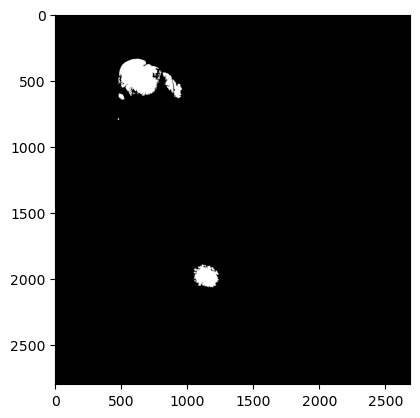

In [50]:
print("sample_from_xml_reference_mask_mir_path", sample_from_xml_reference_mask_mir_path)
print("mask_downsapmle_level", mask_downsapmle_level)

openslide_mask = openslide.open_slide(sample_from_xml_reference_mask_mir_path)

openslide_mask_thumbnail = openslide_mask.read_region(
    (0, 0),
    mask_downsapmle_level,
    openslide_mask.level_dimensions[mask_downsapmle_level]
)
openslide_mask_thumbnail_np = np.array(openslide_mask_thumbnail)

print("Shape:", openslide_mask_thumbnail_np.shape)
print("Min values across channels:", openslide_mask_thumbnail_np.min(axis=(0,1)))
print("Max values across channels", openslide_mask_thumbnail_np.max(axis=(0,1)))
plt.imshow(openslide_mask_thumbnail_np[:, :, 0], cmap='gray')

In [51]:
openslide_spacing = (
    float(openslide_slide.properties['openslide.mpp-x']),
    float(openslide_slide.properties['openslide.mpp-y'])
    )

# possible to use openslide_slide.dimensions and openslide_spacing
# annotation_mask.convert(
#     annotation_list,
#     sample_from_xml_reference_mask_openslide_path,
#     openslide_slide.dimensions,
#     openslide_spacing,
#     label_map,
#     conversion_order
# )

In [52]:
assert mr_image.getDimensions() == openslide_slide.dimensions
assert np.allclose(np.array(mr_image.getSpacing()), np.array(openslide_spacing))